#0.1 Text Classification
#The task is to build a machine learning model to classify whether a particular tweet is hate
speech or not.
0.1.1 Table of Contents
1. About the Dataset
2. Text Cleaning
3. Feature Engineering
4. Train an ML model for Text Classification
5. Evaluate the ML model
6. Conclusion

In [ ]:
  # import libraries
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LogisticRegressionCV
import re
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
#Load the dataset
import pandas as pd

df_hate = pd.read_csv('/content/hate_speech.csv')
df_hate.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
df_hate.shape

(5242, 3)

In [ ]:
df_hate.columns

Index(['id', 'label', 'tweet'], dtype='object')

In [ ]:
df_hate.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5242.0,7798.987409,9403.047132,1.0,1311.25,2621.5,13289.75,31961.0
label,5242.0,0.427699,0.494792,0.0,0.00,0.0,1.00,1.0


In [ ]:
df_hate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5242 entries, 0 to 5241
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5242 non-null   int64 
 1   label   5242 non-null   int64 
 2   tweet   5242 non-null   object
dtypes: int64(2), object(1)
memory usage: 123.0+ KB


In [ ]:
df_hate.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [ ]:
df_hate.dtypes

id        int64
label     int64
tweet    object
dtype: object

#1 means it's hate speech and 0 means not hate speech

In [ ]:
df_hate.label.value_counts()

0    3000
1    2242
Name: label, dtype: int64

In [ ]:
df_hate.label.value_counts()
for index, tweet in enumerate(df_hate["tweet"][10:15]):
    print(index+1,".",tweet)

1 .  â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex
2 . we are so selfish. #orlando #standwithorlando #pulseshooting #orlandoshooting #biggerproblems #selfish #heabreaking   #values #love #
3 . i get to see my daddy today!!   #80days #gettingfed
4 . ouch...junior is angryð#got7 #junior #yugyoem   #omg 
5 . i am thankful for having a paner. #thankful #positive     


#0.1.3 2. Data Cleaning
Let’s clean up the noise in our dataset.

In [ ]:
import re

#Clean text from noise
def clean_text(text):
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)

    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    #Convert to lowercase to maintain consistency
    text = text.lower()

    return text

In [ ]:
df_hate['clean_text'] = df_hate.tweet.apply(lambda x: clean_text(x))

In [ ]:
df_hate.head(10)

,id,label,tweet,clean_text
0,1,0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i can't us...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide society now motivation
5,6,0,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...,user camping tomorrow user user user use...
7,8,0,the next school year is the year for exams.ð...,the next school year is the year for exams ...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land allin cavs champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...,user user welcome here i'm it's so gr...


#Feature Engineering

#• Feature engineering is the science (and art) of extracting more information from existing data.
You are not adding any new data here, but you are actually making the data you already
have more useful.
• The machine learning model does not understand text directly, so we create numerical
features that reperesant the underlying text.
• In this module, you’ll deal with very basic NLP based features and as you progress further
in the course you’ll come across more complex and efficient ways of doing the same

In [ ]:
STOP_WORDS = ['a', 'about', 'above', 'after', 'again', 'against', 'all', 'also', 'am', 'an', 'and',
              'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below',
              'between', 'both', 'but', 'by', 'can', "can't", 'cannot', 'com', 'could', "couldn't", 'did',
              "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'else', 'ever',
              'few', 'for', 'from', 'further', 'get', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having',
              'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how',
              "how's", 'however', 'http', 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it',
              "it's", 'its', 'itself', 'just', 'k', "let's", 'like', 'me', 'more', 'most', "mustn't", 'my', 'myself',
"that's", 'the', 'their', 'theirs',
              'them', 'themselves', 'then', 'there', "there's", 'these', 'they', "they'd", "they'll", "they're",
              "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', "wasn't",
              'we', "we'd", "we'll", "we're", "we've", 'were', "weren't", 'what', "what's", 'when', "when's", 'where',
              "where's", 'which', 'while', 'who', "who's", 'whom', 'why', "why's", 'with', "won't", 'would', "wouldn't",
              'www', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
#Generate word frequency
def gen_freq(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Drop the stopwords during the frequency calculation
    word_freq = word_freq.drop(STOP_WORDS, errors='ignore')

    return word_freq

In [ ]:
 #Check whether a negation term is present in the text
def any_neg(words):
  for word in words:
     if word in ['n', 'no', 'non', 'not'] or re.search(r"\wn't", word):
       return 1
     else:
       return 0
#Check whether one of the 100 rare words is present in the text
def any_rare(words, rare_100):
   for word in words:
     if word in rare_100:
        return 1
     else:
        return 0
#Check whether prompt words are present
def is_question(words):
   for word in words:
       if word in ['when', 'what', 'how', 'why', 'who']:
         return 1
       else:
          return 0

#Generating word frequency method for making new columns

In [ ]:
word_freq = gen_freq(df_hate.clean_text.str)
#100 most rare words in the dataset
rare_100 = word_freq[-100:]
#Number of words in a tweet
df_hate['word_count'] = df_hate.clean_text.str.split().apply(lambda x: len(x))
#Negation present or not
df_hate['any_neg'] = df_hate.clean_text.str.split().apply(lambda x: any_neg(x))
#Prompt present or not
df_hate['is_question'] = df_hate.clean_text.str.split().apply(lambda x:is_question(x))
#Any of the most 100 rare words present or not
df_hate['any_rare'] = df_hate.clean_text.str.split().apply(lambda x:any_rare(x, rare_100))
#Character count of the tweet
df_hate['char_count'] = df_hate.clean_text.apply(lambda x: len(x))


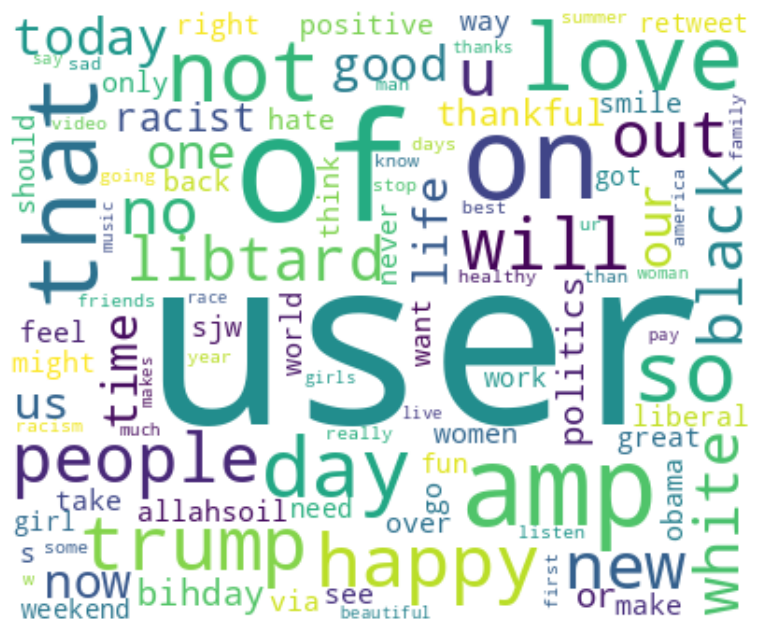

In [ ]:
#Import libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100,
        background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 8))
plt.imshow(wc,interpolation='bilinear')#interpolation)
plt.axis('off')
plt.show()

In [ ]:
#Top 10 common words are
gen_freq(df_hate.clean_text.str)[:10]


user     3351
of        893
on        482
amp       439
that      354
love      320
so        279
not       269
day       254
trump     214
dtype: int64

In [ ]:
#Last five words
#Top 10 common words are
gen_freq(df_hate.clean_text.str)[:10]

user     3351
of        893
on        482
amp       439
that      354
love      320
so        279
not       269
day       254
trump     214
dtype: int64

In [ ]:
df_hate.head()

,id,label,tweet,clean_text,word_count,any_neg,is_question,any_rare,char_count
0,1,0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is s...,18,0,0,0,102
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i can't us...,19,0,0,0,122
2,3,0,bihday your majesty,bihday your majesty,3,0,0,0,21
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ...,12,0,0,0,86
4,5,0,factsguide: society now #motivation,factsguide society now motivation,4,0,0,0,39


In [ ]:
df_hate.isnull().sum()

id             0
label          0
tweet          0
clean_text     0
word_count     0
any_neg        0
is_question    0
any_rare       0
char_count     0
dtype: int64

In [ ]:
df_hate.dtypes

id              int64
label           int64
tweet          object
clean_text     object
word_count      int64
any_neg         int64
is_question     int64
any_rare        int64
char_count      int64
dtype: object

In [ ]:
df_hate.head(10)

,id,label,tweet,clean_text,word_count,any_neg,is_question,any_rare,char_count
0,1,0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is s...,18,0,0,0,102
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i can't us...,19,0,0,0,122
2,3,0,bihday your majesty,bihday your majesty,3,0,0,0,21
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ...,12,0,0,0,86
4,5,0,factsguide: society now #motivation,factsguide society now motivation,4,0,0,0,39
5,6,0,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before the...,18,0,0,0,116
6,7,0,@user camping tomorrow @user @user @user @use...,user camping tomorrow user user user use...,11,0,0,0,74
7,8,0,the next school year is the year for exams.ð...,the next school year is the year for exams ...,20,0,0,0,143
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land allin cavs champ...,10,0,0,0,87
9,10,0,@user @user welcome here ! i'm it's so #gr...,user user welcome here i'm it's so gr...,8,0,0,0,50


#vectoirization for extract features from the dataframe

In [ ]:
#import libraries
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
porter = PorterStemmer()
def tokenizer_porter(text):
   return [porter.stem(word) for word in text.split()]

In [ ]:
tfidf = TfidfVectorizer(strip_accents=None,
lowercase=False,
preprocessor=None,
tokenizer=tokenizer_porter,
use_idf=True,
norm='l2',
smooth_idf=True)
X = tfidf.fit_transform(df_hate['clean_text'])
y = df_hate.label.values

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
X.shape

(5242, 9896)

#.1.5 Splitting the dataset into Train-Test split
• The dataset is split into train and test sets so that we can evaluate our model’s performance
on unseen data.
• The model will only be trained on the train set and will make predictions on the test set
whose data points the model has never seen. This will make sure that we have a proper way
to test the model.
This is a pretty regular practice in Machine Learning, don’t worry if you are confused. It’s just a
way of testing your model’s performance on unseen data

In [ ]:
from sklearn.model_selection import train_test_split
X = tfidf.fit_transform(df_hate['clean_text'])
y = df_hate.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
X_train.shape

(4193, 9896)

In [ ]:
X_test.shape

(1049, 9896)

In [ ]:
y_train.shape

(4193,)

In [ ]:
y_test.shape

(1049,)

#0.1.6 4. Train an ML model for Text Classification
Now that the dataset is ready, it is time to train a Machine Learning model on the same. You
will be using a Random Forest classifier from sklearn which is a prominent python library used for
machine learning

#RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameters={'bootstrap':False,
            'min_samples_leaf':3,
            'n_estimators':100,
            'min_samples_split':10,
            'max_features':'sqrt',
            'max_depth':10
            }
clf_rf=RandomForestClassifier(**parameters)
clf_rf.fit(X_train,y_train)
clf_pred=clf_rf.predict(X_test).astype(int)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(confusion_matrix(y_test,clf_pred))
print(classification_report(y_test,clf_pred))
print("Accuracy:",accuracy_score(y_test,clf_pred))

[[606   0]
 [320 123]]
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       606
           1       1.00      0.28      0.43       443

    accuracy                           0.69      1049
   macro avg       0.83      0.64      0.61      1049
weighted avg       0.80      0.69      0.64      1049

Accuracy: 0.6949475691134414


##cross validation on Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [ ]:
val_score=cross_val_score(clf_rf,X_train,y_train.ravel(),cv=15)

In [ ]:
val_score

array([0.675     , 0.65714286, 0.71071429, 0.67857143, 0.70357143,
       0.68928571, 0.65714286, 0.66071429, 0.65591398, 0.68100358,
       0.68100358, 0.65591398, 0.64157706, 0.70967742, 0.6702509 ])

In [ ]:
val_score.mean()

0.6751655572623314

In [ ]:
val_score.std()

0.020482362826426296

#Randomizedsearch cv with random forest

In [ ]:
import numpy as np

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 90, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,9]
# Minimum number of samples required to split a node
min_samples_split = [2, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2,3,4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 18, 27, 36, 45, 54, 63, 72, 81, 90], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 9], 'min_samples_split': [2, 7], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True, False]}


In [ ]:
modelRF = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = modelRF, param_distributions = param_grid, cv = 19, verbose=2, n_jobs = 4)

In [ ]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 19 folds for each of 10 candidates, totalling 190 fits


RandomizedSearchCV(cv=19, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 9],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 7],
                                        'n_estimators': [10, 18, 27, 36, 45, 54,
                                                         63, 72, 81, 90]},
                   verbose=2)

In [ ]:
rf_RandomGrid.best_params_

{'n_estimators': 10,
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 9,
 'bootstrap': False}

In [ ]:
rf_pred_RandomGrid=rf_RandomGrid.predict(X_test)

In [ ]:
#See the output inconfusion matrix
cm_modelRF=confusion_matrix(y_test,rf_pred_RandomGrid)
cm_modelRF

array([[597,   9],
       [290, 153]])

Text(158.22222222222223, 0.5, 'Truth or Actual Values')

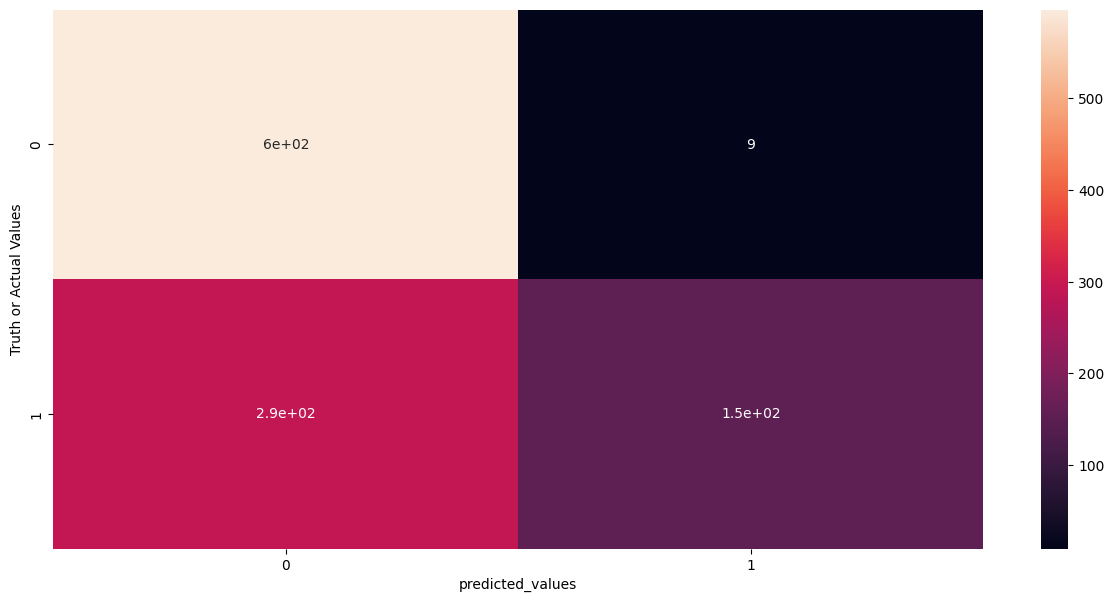

In [ ]:
#Plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(15,7))
sns.heatmap(cm_modelRF,annot=True)
plt.xlabel("predicted_values")
plt.ylabel("Truth or Actual Values")

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(confusion_matrix(y_test,rf_pred_RandomGrid))
print(classification_report(y_test,rf_pred_RandomGrid))
print("Accuracy:",accuracy_score(y_test,rf_pred_RandomGrid))

[[597   9]
 [290 153]]
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       606
           1       0.94      0.35      0.51       443

    accuracy                           0.71      1049
   macro avg       0.81      0.67      0.65      1049
weighted avg       0.79      0.71      0.68      1049

Accuracy: 0.7149666348903718


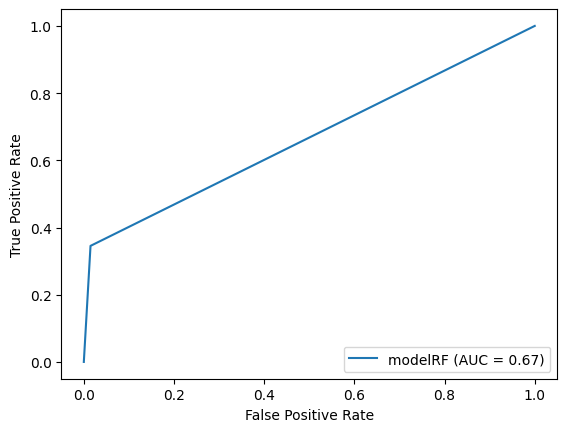

In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_pred_RandomGrid)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='modelRF')
display.plot()
plt.show()

#SVM  classifier

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit (X_train,y_train)
# Generate predictions.
y_preds = svc.predict(X_test)

In [ ]:
## Measure performance based on accuracy.
accuracy_score(y_test,y_preds)

0.8760724499523356

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(confusion_matrix(y_test,y_preds))
print(classification_report(y_test,y_preds))
print("Accuracy:",accuracy_score(y_test,y_preds))

[[557  49]
 [ 81 362]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       606
           1       0.88      0.82      0.85       443

    accuracy                           0.88      1049
   macro avg       0.88      0.87      0.87      1049
weighted avg       0.88      0.88      0.88      1049

Accuracy: 0.8760724499523356


#cross validation

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [ ]:
val_score=cross_val_score(svc,X_train,y_train.ravel(),cv=2)

In [ ]:
val_score

array([0.85026228, 0.84828244])

In [ ]:
val_score.mean()

0.8492723610974602

In [ ]:
val_score.std()

0.0009899183493685682

#Hyperparameter tunning using svm

In [ ]:
# Instantiate SVM.

svc = SVC (

    C = 100,
    kernel = "rbf",
    gamma = "scale"
)

# Fit on training data.

svc.fit(X_train, y_train)

# Evaluate model.

#accuracy_score(y_test, svc.predict(X_test))

SVC(C=100)

In [ ]:
# Generate predictions.
y_predh = svc.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(confusion_matrix(y_test,y_predh))
print(classification_report(y_test,y_predh))
print("Accuracy:",accuracy_score(y_test,y_predh))

[[551  55]
 [ 69 374]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       606
           1       0.87      0.84      0.86       443

    accuracy                           0.88      1049
   macro avg       0.88      0.88      0.88      1049
weighted avg       0.88      0.88      0.88      1049

Accuracy: 0.8817921830314586


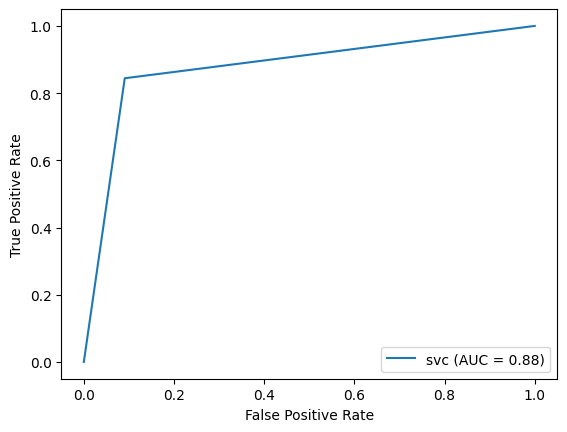

In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predh)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='svc')
display.plot()
plt.show()

In [ ]:
#See the output inconfusion matrix
cm_svc=confusion_matrix(y_test,y_predh)
cm_svc

array([[551,  55],
       [ 69, 374]])

Text(158.22222222222223, 0.5, 'Truth or Actual Values')

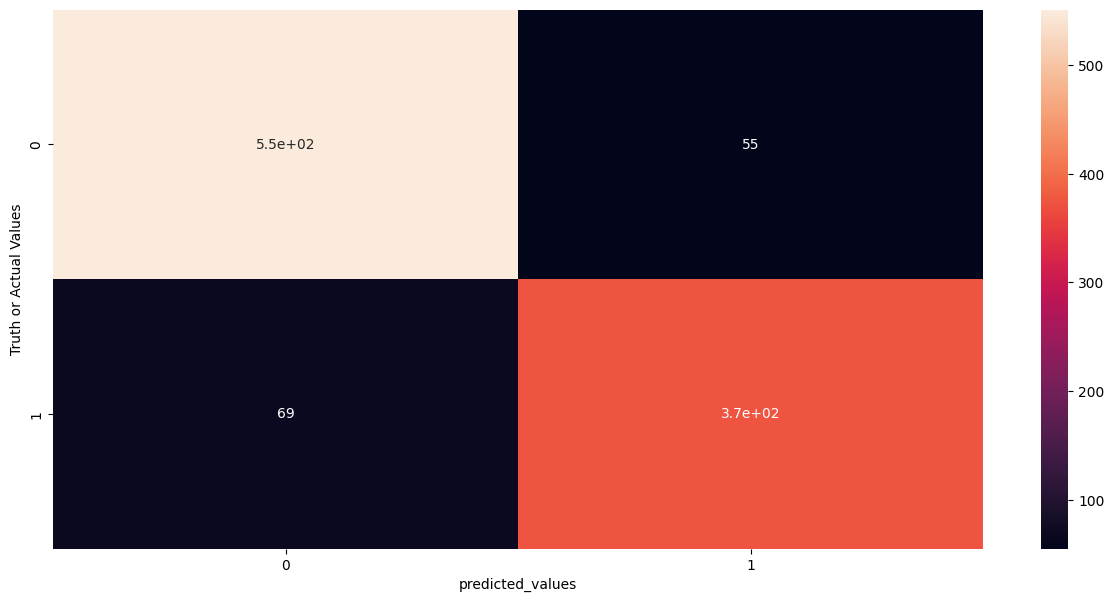

In [ ]:
#Plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(15,7))
sns.heatmap(cm_svc,annot=True)
plt.xlabel("predicted_values")
plt.ylabel("Truth or Actual Values")

#Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier=LogisticRegression()

In [ ]:
classifier.fit(X_train,y_train)

LogisticRegression()

In [ ]:
classifier.score(X_test,y_test)

0.8608198284080076

##cross validation on logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
val_score=cross_val_score(classifier,X_train,y_train.ravel(),cv=2)

In [ ]:
val_score

array([0.83690987, 0.82681298])

In [ ]:
val_score.mean()

0.831861424171936

In [ ]:
val_score.std()

0.0050484470726993025

#Gridsearchcv on logistic regression

In [ ]:
from sklearn.model_selection import GridSearchCV
parameter={'penalty':['l1','l2','elasticnet'],'C':[1,2,3,4,5,6,10,20,30,40,50],'max_iter':[100,200,300]}

In [ ]:
classifier_regressor=GridSearchCV(classifier,param_grid=parameter,scoring='accuracy',cv=5)

In [ ]:
GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 10, 20, 30, 40, 50],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 10, 20, 30, 40, 50],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

In [ ]:
classifier_regressor.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
330 fits failed out of a total of 495.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
165 fits failed with the following error:
Trac

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 10, 20, 30, 40, 50],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

In [ ]:
print(classifier_regressor.best_params_)

{'C': 10, 'max_iter': 100, 'penalty': 'l2'}


In [ ]:
print(classifier_regressor.best_score_)

0.8714534008835384


In [ ]:
##prediction
y_predlo=classifier_regressor.predict(X_test)

In [ ]:
print(y_predlo)

[0 1 0 ... 1 0 0]


In [ ]:
## accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report

In [ ]:
score=accuracy_score(y_predlo,y_test)
print(score)

0.8846520495710201


In [ ]:
print(classification_report(y_predlo,y_test))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       605
           1       0.86      0.86      0.86       444

    accuracy                           0.88      1049
   macro avg       0.88      0.88      0.88      1049
weighted avg       0.88      0.88      0.88      1049



In [ ]:
#See the output inconfusion matrix
cm_lo=confusion_matrix(y_test,y_predlo)
cm_lo

array([[545,  61],
       [ 60, 383]])

Text(158.22222222222223, 0.5, 'Truth or Actual Values')

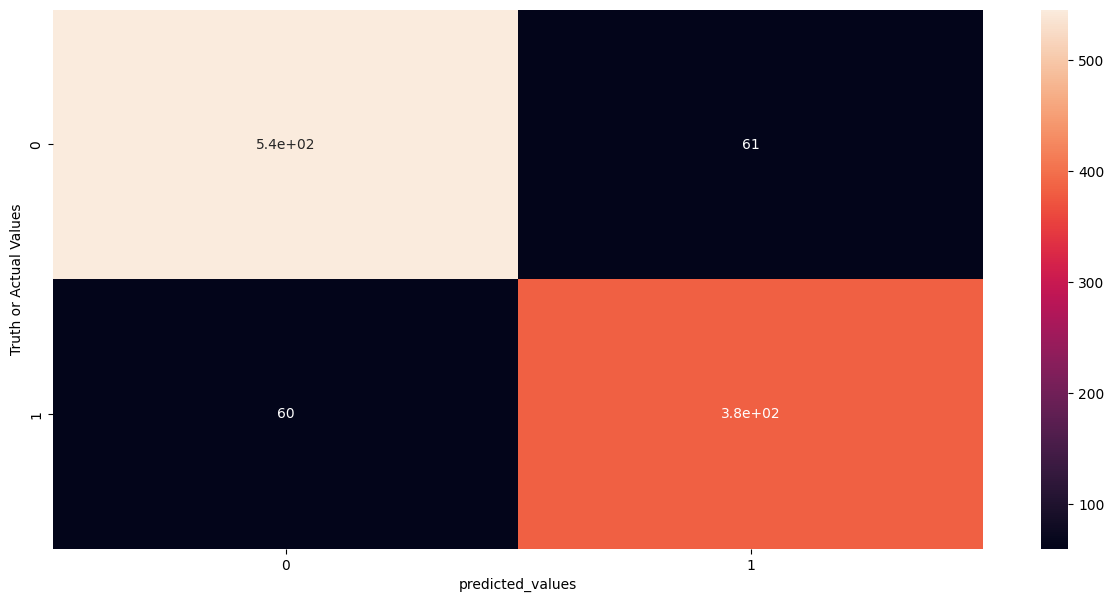

In [ ]:
#Plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(15,7))
sns.heatmap(cm_lo,annot=True)
plt.xlabel("predicted_values")
plt.ylabel("Truth or Actual Values")

In [ ]:
mean_squared_error(y_test,y_predlo)

0.11534795042897998

In [ ]:
r2_score(y_test,y_predlo)

0.5271923354863702

In [ ]:
roc_auc_score(y_test,y_predlo)

0.8819498767032461

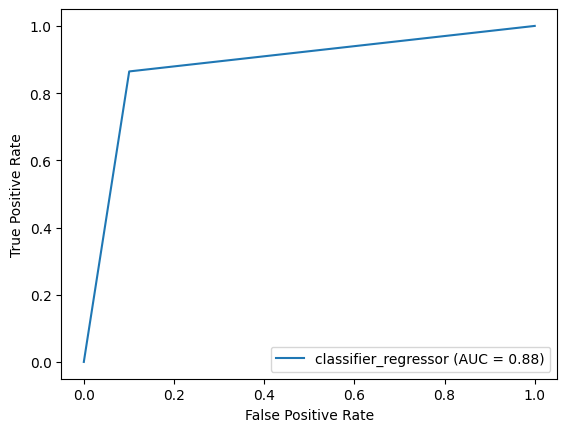

In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predlo)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='classifier_regressor')
display.plot()
plt.show()

#final score

In [ ]:
#final score of our algorithms
print("randomforest:",accuracy_score(y_test,rf_pred_RandomGrid))
print("svc:",accuracy_score(y_test,y_predh))
print("Logi:",accuracy_score(y_test,y_predlo))

randomforest: 0.7149666348903718
svc: 0.8817921830314586
Logi: 0.8846520495710201


#Conclusion

# Evaluation of the model-Both of algorithm's  accuracy scores are same.but based on precision and recall mean value means f1-score gives us nearby value from hundred.they also same so we can go compare it based on the values of misclassification of both algos.so finally we can say our best model based on f1-sore is svc.hyperparameter.It gives us closer value to hundred and also less misclassification. support vector machine classifier is our best model gives us 88% accuracy.we get 90% for 0 means not hate_speech class and we get 86% for 1 means hate_speech class in prediction.